# Amazon Deforestation Forecasting Using AI/ML and IoT Data
## AAI-530 Team 8 Final Project

Team 8:  Tyler Foreman

University of San Diego, Applied Artificial Intelligence

Date:  Feburary 11, 2023

GitHub Repository: https://github.com/t4ai/amazon-deforestation-forecasting

In [1]:
# install necessary libraries
!pip install geopandas

In [7]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from sklearn.cluster import KMeans


## Exploratory Data Analysis

Load geospatial shape files and evaluate.  Objectives are:

1.  Interrogate time series layer: yearly_deforsestation_biome
2.  Visualize the time series layer
3.  Check for mising values
4.  Evaluate value ranges of target variable
5.  Interrogate supporting layers and determine how to create normalized analytical dataset


In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load geo data layers
root_dir = '/content/drive/MyDrive/USD/datasets/amazon_deforestation'
geo_yearly_deforestation_biome = gpd.read_file(root_dir + '/yearly_deforestation_biome/yearly_deforestation_biome.shp')
geo_states_amazon_biome = gpd.read_file(root_dir + '/states_amazon_biome/states_amazon_biome.shp')
geo_hydrography_biome = gpd.read_file(root_dir + '/hydrography_biome/hydrography_biome.shp')
geo_no_forest_biome = gpd.read_file(root_dir + '/no_forest_biome/no_forest_biome.shp')

### Interrogate the time series data layer

In [6]:
# display some samples
geo_yearly_deforestation_biome.sample(5)

,fid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry
645119,304529,PA,22466,DESMATAMENTO,d2009,0.0,220,2009-08-08,2009.0,0.204980,879.0,None,None,None,7483d079-c13c-4617-a819-25d90019e533,"POLYGON ((-50.64829 -9.11289, -50.64775 -9.112..."
634059,293356,RO,23267,DESMATAMENTO,d2016,0.0,200,2016-07-18,2016.0,0.047886,100246.0,None,None,None,9d5e153a-1bb8-495a-9949-b364a48fbdf6,"POLYGON ((-63.55738 -9.63049, -63.55738 -9.626..."
267084,537584,PA,22463,DESMATAMENTO,d2015,0.0,253,2015-09-10,2015.0,0.000019,2574.0,None,None,None,fcf4cc89-11b6-414b-9f66-d340f2d38981,"POLYGON ((-49.29495 -4.03690, -49.29495 -4.036..."
157783,446752,PA,22663,DESMATAMENTO,d2016,0.0,206,2016-07-24,2016.0,0.066167,100312.0,None,None,None,d14428a4-fcb0-40ce-878e-1e82c2735d84,"POLYGON ((-52.42078 -3.72384, -52.42073 -3.723..."
349009,546329,PA,22562,DESMATAMENTO,d2022,NaN,263,2022-09-20,2022.0,0.000005,1495.0,Amazonia,Landsat,OLI,94938eb5-c4f1-49d6-8f75-c391003ecc9d,"POLYGON ((-51.81478 -2.54962, -51.81479 -2.549..."


In [9]:
# print descriptive statistics
geo_yearly_deforestation_biome.describe()

,fid,def_cloud,julian_day,year,area_km,scene_id
count,666304.000000,510630.000000,666304.000000,666304.000000,666304.000000,665727.000000
mean,333152.500000,321.841846,219.746364,2015.468742,0.174381,20848.936883
std,192345.541219,737.740580,32.035579,4.530961,0.550267,39564.416673
min,1.000000,0.000000,1.000000,2008.000000,0.000000,1.000000
25%,166576.750000,0.000000,207.000000,2011.000000,0.065143,804.000000
50%,333152.500000,0.000000,219.000000,2016.000000,0.090982,1401.000000
75%,499728.250000,0.000000,233.000000,2019.000000,0.153751,2559.000000
max,666304.000000,2021.000000,363.000000,2022.000000,123.475783,101293.000000


In [11]:
#check data types
geo_yearly_deforestation_biome.dtypes

fid              int64
state           object
path_row        object
main_class      object
class_name      object
def_cloud      float64
julian_day       int64
image_date      object
year           float64
area_km        float64
scene_id       float64
source          object
satellite       object
sensor          object
uuid            object
geometry      geometry
dtype: object

In [12]:
# convert image_date to datetime
geo_yearly_deforestation_biome['image_date'] = pd.to_datetime(geo_yearly_deforestation_biome['image_date'])

<ipython-input-19-6ab8cb77a01f>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_deforestation = geo_yearly_deforestation_biome.groupby(pd.Grouper(key="image_date", freq="1Y")).sum()


<Axes: xlabel='image_date'>

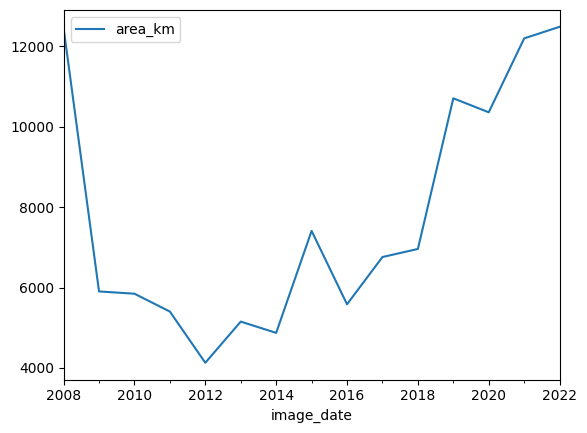

In [19]:
# visualize the area_km total by year
yearly_deforestation = geo_yearly_deforestation_biome.groupby(pd.Grouper(key="image_date", freq="1Y")).sum()
yearly_deforestation['image_date'] = yearly_deforestation.index
yearly_deforestation.plot(x="image_date", y="area_km", kind="line")

In [39]:
# visualize the area_km total by state by year
state_deforestation = geo_yearly_deforestation_biome.groupby(['state', pd.Grouper(key="image_date", freq="1Y")]).sum()

<ipython-input-39-ad7e65832fbe>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  state_deforestation = geo_yearly_deforestation_biome.groupby(['state', pd.Grouper(key="image_date", freq="1Y")]).sum()


In [40]:
state_deforestation

fid  def_cloud  julian_day       year     area_km  \
state image_date                                                            
AC    2008-12-31  826890113   303057.0      629500  5433648.0  288.792419   
      2009-12-31  518115260     8031.0      423648  3471552.0  161.738798   
      2010-12-31  813567682  1018516.0      577216  5374740.0  265.366641   
      2011-12-31  924697382    68333.0      688288  6149638.0  295.785591   
      2012-12-31  760215623   249362.0      546148  5176876.0  270.534694   
...                     ...        ...         ...        ...         ...   
TO    2018-12-31   16060203        0.0       10505   104936.0    4.760367   
      2019-12-31   19752636     2018.0       16298   147387.0    9.619698   
      2020-12-31   23576626        0.0       16767   149480.0   10.115500   
      2021-12-31   23891082        0.0       16586   147533.0   11.300232   
      2022-12-31   70207011        0.0       35250   299256.0   16.442140   

                   scene_id  
state image_date             
AC    2008-12-31  1758175.0  
      2009-12-31  1536732.0  
      2010-12-31  3008895.0  
      2011-12-31  3960568.0  
      2012-12-31  4032307.0  
...                     ...  
TO    2018-12-31  5256270.0  
      2019-12-31     4196.0  
      2020-12-31    48622.0  
      2021-12-31    81571.0  
      2022-12-31   232259.0  

[135 rows x 6 columns]

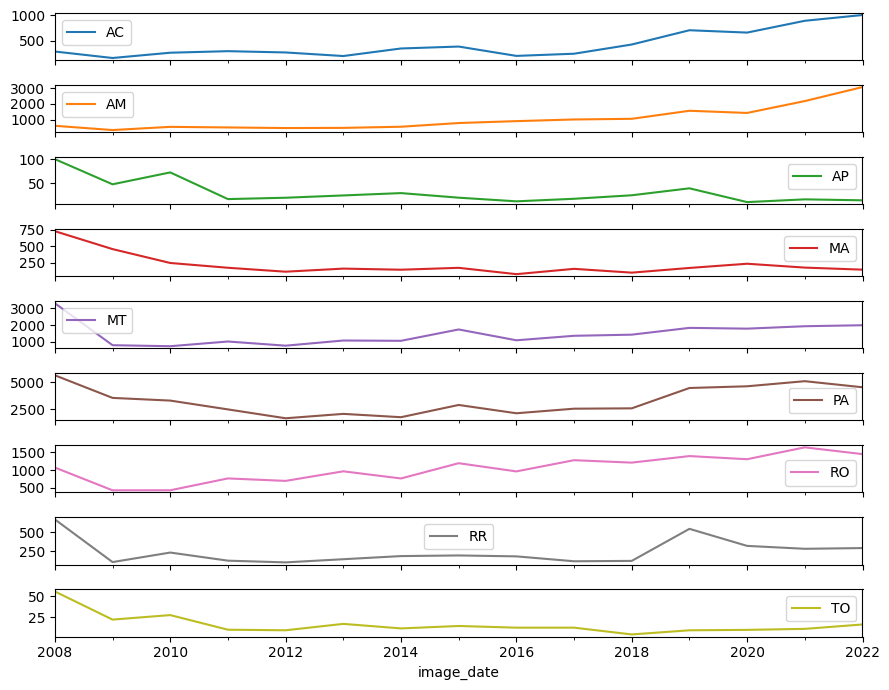

In [42]:
# plot by state
ax = state_deforestation.unstack(level=0).plot(kind='line', y='area_km', subplots=True, rot=0, figsize=(9, 7))
plt.tight_layout()